![Colegio Bourbaki](./Images/Bourbaki.png)

## Machine Learning & AI

### Modelos Multimodales de Texto e Imágenes

### Contexto

Fue en enero de 2021 cuando **OpenAI** anunció dos nuevos modelos: **DALL-E** y **CLIP**, ambos modelos **multimodales** que conectan **textos e imágenes** de alguna manera. 

Vamos a implementar el modelo CLIP desde cero en **PyTorch**. 


### CLIP: Modelo Texto-Imagen

En [Learning Transferable Visual Models From Natural Language Supervision paper](https://arxiv.org/abs/2103.00020), OpenAI presenta su nuevo modelo denominado **CLIP**, por **Contrastive Language-Image Pre-training**. En pocas palabras, este modelo aprende la relación entre una frase completa y la imagen que describe; en el sentido de que cuando el modelo está entrenado, dada una frase de entrada será capaz de recuperar las imágenes más relacionadas correspondientes a esa frase. Lo importante aquí es que se entrena con frases completas en lugar de con clases individuales como coche, perro, etc. La intuición es que cuando se entrena con frases completas, el modelo puede aprender muchas más cosas y encuentra algún patrón entre imágenes y textos.

También demuestran que cuando este modelo se entrena con un enorme conjunto de datos de imágenes y sus correspondientes textos, también puede actuar como clasificador. Le animo a estudiar el artículo para saber más sobre este interesante modelo y sus sorprendentes resultados en conjuntos de datos de referencia. Por mencionar sólo uno, ¡el modelo CLIP entrenado con esta estrategia clasifica ImageNet mejor que los modelos SOTA entrenados en la propia ImageNet optimizada para la única tarea de clasificación!

A modo de preparacion, veamos de qué es capaz el modelo final que construiremos. Dada una consulta (texto en bruto) como "un chico saltando con monopatín" o "una chica saltando desde un columpio", el modelo recuperará las imágenes más relevantes:

![teaser1](./Images/teaser.png)

Veamos otra salida:

![teaser2](./Images/dogs.png)

### Librerías

In [23]:
#Pytorch
import torch

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
import timm

#Pretrained Models
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer

#Utils
import albumentations as A
import cv2
import itertools
import numpy as np
import pandas as pd
import os
import sys
from dataclasses import dataclass, field
from tqdm.autonotebook import tqdm
from tqdm import tqdm

### Configuraciones

In [2]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
!set 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:2'
torch.cuda.empty_cache()
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False

In [3]:
print("__Python VERSION:", sys.version)
print("__pyTorch VERSION:", torch.__version__)
print(
    "__CUDA VERSION",
)
! nvidia-smi
print("__CUDNN VERSION:", torch.backends.cudnn.version())
print("__Number CUDA Devices:", torch.cuda.device_count())
print("__Devices")
print("Active CUDA Device: GPU", torch.cuda.current_device())
print("Available devices ", torch.cuda.device_count())
print("Current cuda device ", torch.cuda.current_device())

__Python VERSION: 3.11.8 (main, Feb  9 2024, 16:48:53) [GCC 11.4.0]
__pyTorch VERSION: 2.2.0+cu121
__CUDA VERSION
Wed Feb 28 00:11:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti     On  | 00000000:01:00.0 Off |                  N/A |
| N/A   53C    P8               2W /  30W |      6MiB /  4096MiB |      0%      Default |
|                                         | 

### Configuraciones del Modelo (setup)

La clase de configuración proporcionada (CFG) describe los ajustes del modelo.

El uso de modelos preentrenados (resnet50 para imágenes y distilbert-base-uncased para texto) aprovecha el enfoque que aprovecha el aprendizaje por transferencia (Transfer Learning), ajustando modelos que han sido preentrenados en grandes conjuntos de datos para beneficiarse de representaciones aprendidas previamente.

In [21]:
@dataclass
class CFG:
    # Paths
    image_path: str = "./Data/Images"
    captions_path: str = "./Data"
    
    # Training Parameters
    batch_size: int = 8
    num_workers: int = 0
    epochs: int = 4
    
    # Learning Rates
    head_lr: float = 1e-3
    image_encoder_lr: float = 1e-4
    text_encoder_lr: float = 1e-5
    weight_decay: float = 1e-3
    
    # Early Stopping
    patience: int = 1
    factor: float = 0.8
    
    # Model Configuration
    model_name: str = 'resnet50'
    image_embedding: int = 2048
    text_encoder_model: str = "distilbert-base-uncased"
    text_embedding: int = 768
    text_tokenizer: str = "distilbert-base-uncased"
    max_length: int = 200
    pretrained: bool = True
    trainable: bool = True
    temperature: float = 1.0
    size: int = 128
    
    # Projection Head Configuration
    num_projection_layers: int = 1
    projection_dim: int = 256
    dropout: float = 0.1
    
    # Device Configuration
    device: torch.device = field(default_factory=lambda: torch.device("cuda" if torch.cuda.is_available() else "cpu"))

In [4]:
# class CFG:
#     debug = False
#     image_path = "./Data/Images"
#     captions_path = "./Data"
#     batch_size = 8 #16
#     num_workers = 0
#     head_lr = 1e-3
#     image_encoder_lr = 1e-4
#     text_encoder_lr = 1e-5
#     weight_decay = 1e-3
#     patience = 1
#     factor = 0.8
#     epochs = 4
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#     model_name = 'resnet50'
#     image_embedding = 2048
#     text_encoder_model = "distilbert-base-uncased"
#     text_embedding = 768
#     text_tokenizer = "distilbert-base-uncased"
#     max_length = 200

#     pretrained = True # for both image encoder and text encoder
#     trainable = True # for both image encoder and text encoder
#     temperature = 1.0

#     # image size
#     size = 128

#     # for projection head; used for both image and text encoders
#     num_projection_layers = 1
#     projection_dim = 256
#     dropout = 0.1

### Funciones de ayuda

La clase AvgMeter es una utilidad para el seguimiento de la media, suma y recuento de una métrica particular durante el proceso de entrenamiento o validación del modelo. 

Este enfoque particularmente útil para realizar un seguimiento de las métricas de pérdida y precisión a lo largo de épocas o lotes.

In [22]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]


## Dataset

Necesitamos codificar tanto las imágenes como los textos que describen las imágenes. Por lo tanto, el conjunto de datos debe **devolver tanto imágenes como textos**. 

Por supuesto, no vamos a introducir texto en bruto en nuestro codificador de texto. Utilizaremos el modelo **DistilBERT** (que es más pequeño que BERT pero funciona casi tan bien como BERT) de la biblioteca **HuggingFace** como codificador de texto; por lo tanto, tenemos que **tokenizar** las frases (pies de foto) con el tokenizador de DistilBERT y luego introducir los identificadores de los tokens (input_ids) y las máscaras de atención (attention_masks) a DistilBERT. 

Consecuentemente, el conjunto de datos también debe encargarse de la tokenización.

Veamos cómo construiremos el dataset:

En **\_\_init\_\_** recibimos un objeto tokenizer que es en realidad un tokinzer HuggingFace; este tokenizer se cargará al ejecutar el modelo. Estamos rellenando y truncando los subtítulos a un max_length especificado. 

En **\_\_getitem\_\_** primero cargaremos un título codificado que es un diccionario con las claves input_ids y attention_mask, haremos tensores con sus valores y después cargaremos la imagen correspondiente, la transformaremos y después la convertiremos en un tensor y la pondremos en el diccionario con "image" como clave. Por último, ponemos el texto en bruto del pie de foto con la clave "pie de foto" en el diccionario sólo para fines de visualización.

In [25]:
def get_transforms(mode="train"):
    if mode == "train":
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )
    else:
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )

In [26]:
class CLIPDataset(Dataset):
    def __init__(self, image_filenames, captions, tokenizer, transforms):
        """
        image_filenames and captions must have the same length; so, if there are
        multiple captions for each image, the image_filenames must have repetitive
        file names 
        """

        self.image_filenames = image_filenames
        self.captions = list(captions)
        self.encoded_captions = tokenizer(
            list(captions), padding=True, truncation=True, max_length=CFG.max_length
        )
        self.transforms = transforms

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }

        image = cv2.imread(f"{CFG.image_path}/{self.image_filenames[idx]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)['image']
        item['image'] = torch.tensor(image).permute(2, 0, 1).float()
        item['caption'] = self.captions[idx]

        return item


    def __len__(self):
        return len(self.captions)

### Codificador de Imágenes

El código del codificador de imágenes es sencillo. Usaremos la librería PyTorch Image Models (timm) que pone a nuestra disposición un montón de modelos de imagen diferentes desde ResNets a EfficientNets y muchos más. 

Aquí vamos a utilizar un ResNet50 como nuestro codificador de imágenes. 

Podemos usar la librería torchvision para usar ResNets si no quieres instalar una nueva librería.

![resnet](./Images/resnet50.png)

El código codifica cada imagen en un vector de tamaño fijo con el tamaño de los canales de salida del modelo (en el caso de ResNet50 el tamaño del vector será **2048**). Esta es la salida después de la capa nn.AdaptiveAvgPool2d().

In [27]:
class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector
    """

    def __init__(
        self, model_name=CFG.model_name, pretrained=CFG.pretrained, trainable=CFG.trainable
    ):
        super().__init__()
        self.model = timm.create_model(
            model_name, pretrained, num_classes=0, global_pool="avg"
        )
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

### Codificador de Texto

Como mencionamos antes, utilizaremos DistilBERT como codificador de texto. Al igual que su hermano mayor BERT, se añadirán dos tokens especiales a los tokens de entrada: **CLS** y **SEP**, que marcan el inicio y el final de una frase. Para captar la representación completa de una frase (como señalan los documentos relacionados BERT y DistilBERT) utilizamos las representaciones finales del token CLS y esperamos que esta representación capte el significado global de la frase (caption). Pensándolo así, es similar a lo que hicimos con las imágenes y las convertimos en un vector de tamaño fijo.

En el caso de DistilBERT (y también de BERT) la representación oculta de salida para cada token es un vector de tamaño **768**. Así pues, todo el subtítulo se codificará en la representación de tokens CLS cuyo tamaño es 768.

![resnet](./Images/distillbert.png)

In [28]:
class TextEncoder(nn.Module):
    def __init__(self, model_name=CFG.text_encoder_model, pretrained=CFG.pretrained, trainable=CFG.trainable):
        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig())
            
        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

### Projection Head

Una capa de **proyección** es un componente utilizado en modelos de aprendizaje automático, especialmente en aprendizaje auto-supervisado y aprendizaje contrastivo. Su propósito principal es transformar las representaciones de características producidas por un modelo (como las salidas de la columna vertebral de una red neuronal) en un espacio donde la tarea subsiguiente (por ejemplo, clasificación, comparación o agrupación) se realiza de manera más efectiva. Esto incluye una o más capas completamente conectadas, y puede incluir capas de normalización y funciones de activación no lineales.

Ahora que hemos codificado nuestras imágenes y textos en vectores de tamaño fijo (2048 para la imagen y 768 para el texto) necesitamos traerlos (proyectarlos) a un **nuevo espacio** con **dimensiones similares** para ambas imágenes y textos para poder compararlos y apartar la imagen y textos no relevantes y juntar los que coincidan. Así, el siguiente código traerá los vectores de 2048 y 768 dimensiones a un mundo de 256 (projection_dim) dimensiones, donde podremos **compararlos**.

"embedding_dim" es el tamaño del vector de entrada (2048 para imágenes y 768 para textos) y "projection_dim" es el tamaño del vector de salida, que será 256 en nuestro caso.

In [29]:
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=CFG.projection_dim,
        dropout=CFG.dropout
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)
    
    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

### Modelo CLIP

Aquí vamos a utilizar los módulos anteriores que hemos construido para implementar el modelo principal. 

La función **\_\_init\_\_** se explica por sí misma. En la función forward, primero codificamos las imágenes y los textos por separado en vectores de tamaño fijo (con diferentes dimensionalidades). Después, utilizando módulos de proyección separados, los proyectamos a ese espacio compartido del que hablamos anteriormente. Aquí las codificaciones tendrán una forma similar (256 en nuestro caso). Después calcularemos la pérdida.

En **Álgebra Lineal**, una forma común de medir si dos vectores son de características similares (son parecidos entre sí) es calcular su **producto punto** (multiplicando las entradas coincidentes y tomando la suma de ellas); si el número final es grande, son parecidos y si es pequeño ¡no lo son (relativamente hablando)!

Hemos hablado de dos vectores, pero, ¿qué tenemos aquí? Tenemos image_embeddings, una matriz con forma (batch_size, 256) y text_embeddings con forma (batch_size, 256). Esto significa que tenemos dos grupos de vectores en lugar de dos vectores individuales. ¿Cómo medimos la similitud entre dos grupos de vectores (dos matrices)? De nuevo, con el producto punto (el operador @ en PyTorch hace el producto punto o multiplicación de matrices en este caso). Para poder multiplicar estas dos matrices entre sí, transponemos la segunda. Bien, obtenemos una matriz con forma (tamaño_lote, tamaño_lote) que llamaremos logits. (la temperatura es igual a 1.0 en nuestro caso, así que, no hay diferencia. Pueden jugar con este y ver qué diferencia hace. La temperatura es un factor de escala utilizado para gestionar la nitidez de una distribución.

Ahora que tenemos nuestros logits (outputs), necesitamos objetivos (targets).

Consideremos lo que esperamos que aprenda este modelo: **Queremos que aprenda "representaciones similares (vectores)" para una imagen dada y el título que la describe. Es decir, si le damos una imagen o el texto que la describe, queremos que produzca los mismos 256 vectores para ambos.**

In [30]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=CFG.temperature,
        image_embedding=CFG.image_embedding,
        text_embedding=CFG.text_embedding,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        # Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        # Calculating the Loss
        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()

In [31]:
def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

Así que, en el mejor de los casos, las matrices text_embeddings e image_embedding deberían ser iguales porque describen cosas similares. Pensemos ahora: si esto ocurre, ¿cómo sería la matriz logits? Veámoslo con un ejemplo sencillo.

In [32]:
# A simple Example
batch_size = 4
dim = 256
embeddings = torch.randn(batch_size, dim)
out = embeddings @ embeddings.T
print(F.softmax(out, dim=-1))

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])


Así que logits, en el mejor de los casos, será una matriz que si tomamos su softmax, tendrá 1.0s en la diagonal (¡Una matriz identidad por llamarla con palabras elegantes!). Como el trabajo de la función de pérdida es hacer que las predicciones del modelo sean similares a los objetivos (¡al menos en la mayoría de los casos!), queremos una matriz así como objetivo. Esa es la razón por la que calculamos las matrices images_similarity y texts_similarity en el bloque de código anterior.

Ahora que tenemos nuestra matriz de objetivos, utilizaremos la entropía cruzada simple para calcular la pérdida real.

**IMPORTANTE**: Admitiremos que hay una forma más sencilla de calcular esta pérdida en PyTorch; haciendo esto: nn.CrossEntropyLoss()(logits, torch.arange(batch_size)). ¿Por qué no lo utilizamos aquí? Por 2 razones: 

1) El conjunto de datos que estamos utilizando tiene múltiples leyendas para una sola imagen; por lo tanto, existe la posibilidad de que dos imágenes idénticas con sus leyendas similares existan en un lote (es raro, pero puede suceder). Tomar la pérdida con este método más sencillo ignorará esta posibilidad y el modelo aprenderá a separar dos representaciones (suponerlas diferentes) que en realidad son iguales. Obviamente, no queremos que esto suceda por lo que calculamos toda la matriz objetivo de una manera que se ocupa de estos casos de borde. 

2) Haciéndolo de la manera que en que lo hicimos, nos da mejor comprensión de lo que está sucediendo en esta función de pérdida, por lo que, es más intuitivo para su comprensión.

### Entrenamiento del modelo

In [35]:
def make_train_valid_dfs():
    dataframe = pd.read_csv(f"{CFG.captions_path}/captions.csv")
    max_id = dataframe.index.max() + 1 if not CFG.debug else 100
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[dataframe.index.isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe.index.isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe


def build_loaders(dataframe, tokenizer, mode):
    transforms = get_transforms(mode=mode)
    dataset = CLIPDataset(
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer,
        transforms=transforms,
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        shuffle=True if mode == "train" else False,
    )
    return dataloader

In [36]:
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter

In [37]:
def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter

In [38]:
def main():
    train_df, valid_df = make_train_valid_dfs()
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    train_loader = build_loaders(train_df, tokenizer, mode="train")
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")


    model = CLIPModel().to(CFG.device)
    params = [
        {"params": model.image_encoder.parameters(), "lr": CFG.image_encoder_lr},
        {"params": model.text_encoder.parameters(), "lr": CFG.text_encoder_lr},
        {"params": itertools.chain(
            model.image_projection.parameters(), model.text_projection.parameters()
        ), "lr": CFG.head_lr, "weight_decay": CFG.weight_decay}
    ]
    optimizer = torch.optim.AdamW(params, weight_decay=0.)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=CFG.patience, factor=CFG.factor
    )
    step = "epoch"

    best_loss = float('inf')
    for epoch in range(CFG.epochs):
        print(f"Epoch: {epoch + 1}")
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
        model.eval()
        with torch.no_grad():
            valid_loss = valid_epoch(model, valid_loader)
        
        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), "best.pt")
            print("Saved Best Model!")
        
        lr_scheduler.step(valid_loss.avg)

Ejecutar la siguiente celda empezar a entrenar el modelo. Cada epoch debería tardar menos minutos en la GPU (¡incluso una epoch es suficiente!). Puede llegar a tardar un minuto antes de que empiece el entrenamiento porque vamos a codificar todos los subtítulos una vez en el conjunto de datos válido y de entrenamiento, ¡así que por favor no lo detengas, todo funciona correctamente!

In [14]:
main()

Epoch: 1


100%|██████████| 1012/1012 [01:34<00:00, 10.75it/s, valid_loss=0.992]


Saved Best Model!
Epoch: 2


100%|██████████| 1012/1012 [01:29<00:00, 11.27it/s, valid_loss=0.933]


Saved Best Model!
Epoch: 3


100%|██████████| 1012/1012 [01:29<00:00, 11.37it/s, valid_loss=1.04]


Epoch: 4


100%|██████████| 1012/1012 [01:30<00:00, 11.24it/s, valid_loss=0.907]


Saved Best Model!


## Inferencia

Hemos terminado de entrenar el modelo. Ahora tenemos que hacer la inferencia, que en nuestro caso consistirá en dar al modelo un texto y pedirle que recupere las imágenes más relevantes de un conjunto de validación (o prueba) que no se ha visto.

En esta función, cargamos el modelo que hemos guardado tras el entrenamiento, lo alimentamos con imágenes del conjunto de validación y devolvemos image_embeddings con forma (valid_set_size, 256) y el propio modelo.

In [15]:
def get_image_embeddings(valid_df, model_path):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")
    
    model = CLIPModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    model.eval()
    
    valid_image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            image_features = model.image_encoder(batch["image"].to(CFG.device))
            image_embeddings = model.image_projection(image_features)
            valid_image_embeddings.append(image_embeddings)
    return model, torch.cat(valid_image_embeddings)

In [16]:
_, valid_df = make_train_valid_dfs()
model, image_embeddings = get_image_embeddings(valid_df, "best.pt")

100%|██████████| 1012/1012 [01:02<00:00, 16.29it/s]


Esta función realiza la tarea final que deseábamos que nuestro modelo fuera capaz de hacer: obtiene el modelo, image_embeddings y una consulta de texto. Mostrará las imágenes más relevantes del conjunto de validación. Veamos cómo funciona después de todo:

In [39]:
def find_matches(model, image_embeddings, query, image_filenames, n=9):
    import matplotlib.pyplot as plt
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(CFG.device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)
    
    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T
    
    values, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
    matches = [image_filenames[idx] for idx in indices[::5]]
    
    _, axes = plt.subplots(3, 3, figsize=(10, 10))
    for match, ax in zip(matches, axes.flatten()):
        image = cv2.imread(f"{CFG.image_path}/{match}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")
    
    plt.show()

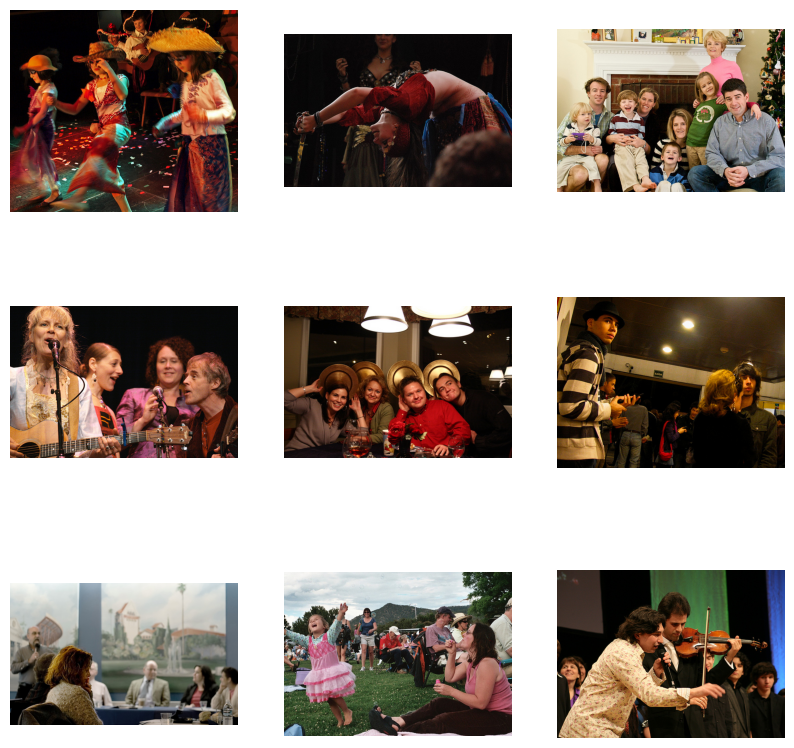

In [18]:
find_matches(model, 
             image_embeddings,
             query="a group of people dancing in a party",
             image_filenames=valid_df['image'].values,
             n=9)

###  Ejercicios

**Fundamentos de CLIP**

* ¿Qué es CLIP y para qué sirve?
* ¿Cómo se entrena CLIP y qué hace único a su enfoque de entrenamiento?
* Explica el concepto de "aprendizaje contrastivo" en el contexto de CLIP.
* ¿Cuáles son las principales diferencias entre CLIP y otros modelos de visión por computadora o procesamiento de lenguaje natural?

**Aspectos Técnicos**

* Describe cómo CLIP procesa las imágenes y los textos para realizar predicciones.
* ¿Cómo contribuye el entrenamiento con un conjunto de datos diverso al rendimiento de CLIP en diferentes tareas?
* Explica cómo CLIP logra ser eficaz en tareas de clasificación de imágenes sin necesidad de entrenamiento específico para esas tareas.

**Aplicaciones y Casos de Uso**

* Proporciona ejemplos de aplicaciones prácticas donde CLIP podría ser particularmente útil.
* ¿Cómo puede CLIP ser utilizado para mejorar los sistemas de búsqueda visual? Proporciona un ejemplo específico.
* ¿Cuáles son las implicaciones éticas y los desafíos potenciales al utilizar modelos como CLIP en aplicaciones del mundo real?

**Comparaciones y Contrastes**

* Compara CLIP con modelos tradicionales de visión por computadora en términos de flexibilidad y generalización.
* ¿En qué se diferencia CLIP de otros modelos de aprendizaje multimodal?

**Reflexión Crítica**

* ¿Cuáles son las limitaciones de CLIP y cómo podrían abordarse en futuras versiones o modelos similares?
* Discute el impacto potencial de la implementación de CLIP en la privacidad y la seguridad de la información.
* Reflexiona sobre cómo el desarrollo de tecnologías como CLIP podría influir en el futuro del procesamiento de lenguaje natural y la visión por computadora.

![](./images/dance.png)

### Referencias:

* The Annotated ResNet-50: https://towardsdatascience.com/the-annotated-resnet-50-a6c536034758
* HuggingFace DistilBERT: https://www.scaler.com/topics/nlp/distilbert/
* Learning Transferable Visual Models From Natural Language Supervision: https://arxiv.org/abs/2103.00020


Adaptado de:

* https://github.com/moein-shariatnia/OpenAI-CLIP/blob/master/OpenAI%20CLIP%20Simple%20Implementation.ipynb

![Lenguaje Matemático](./Images/Matematicas.png)

![Contacto](./Images/Contacto.png)